In [1]:
#  to get automatic reloading
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.plots import *
from fastai.io import get_data
from fastai.conv_learner import *

In [2]:
PATH = "data/emotionet/"
IMGP = "imgs"
csv_path = f"{PATH}uniqueaus6_12.csv"

In [3]:
n = len(list(open(csv_path)))-1
val_idxs = get_cv_idxs(n)
n, len(val_idxs)

(355, 71)

In [4]:
sz = 224
bs = 64
arch=resnet34

**check where is the model looking at**

In [5]:
m = arch(True)

In [6]:
m = nn.Sequential(*children(m)[:-2],
                 nn.Conv2d(512,2,3,padding=1),
                 nn.AdaptiveAvgPool2d(1), Flatten(),
                 nn.LogSoftmax())

In [7]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, IMGP, csv_path, tfms=tfms, bs=bs)

In [8]:
learn = ConvLearner.from_model_data(m, data)

In [20]:
learn.freeze_to(-4)

In [21]:
m[-1].trainable

True

In [22]:
m[-4].trainable

True

In [23]:
learn.fit(1e-4, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy               
    0      13.453632  14.354451  0.56338   



[array([14.35445]), 0.5633802816901409]

In [24]:
learn.precompute=False
learn.fit(1e-4,3,cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy               
    0      12.278671  13.782988  0.56338   
    1      11.527266  11.990532  0.56338                
    2      10.496359  9.575281   0.56338                



[array([9.57528]), 0.5633802816901409]

In [25]:
learn.unfreeze()

In [27]:
learn.fit(1e-4, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy               
    0      7.357953   8.965891   0.56338   
    1      6.291747   6.262047   0.56338                
    2      5.101298   5.261073   0.56338                
    3      4.024265   2.789568   0.746479               
    4      3.074209   2.397336   0.746479               
    5      2.430784   2.30251    0.746479               
    6      1.981379   2.211065   0.746479               



[array([2.21107]), 0.7464788732394366]

In [28]:
# learn.save('224_all_8');
learn.fit(1e-4, 6, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=63), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      0.059088   2.161425   0.732394  
    1      0.046959   2.142878   0.746479                 
    2      0.05264    2.102521   0.746479                 
    3      0.048191   2.134796   0.732394                 
    4      0.040676   2.156873   0.732394                 
    5      0.0373     2.166125   0.732394                 
    6      0.042761   2.124614   0.732394                 
    7      0.038418   2.150791   0.746479                 
    8      0.037323   2.154855   0.746479                 
    9      0.033234   2.148385   0.746479                 
    10     0.030307   2.162687   0.746479                 
    11     0.032468   2.177504   0.746479                 
    12     0.031446   2.180459   0.746479                 
    13     0.029      2.17452    0.746479                 
    14     0.026837   2.196044   0.746479                 
    15     0.026204   2.193299   0.746479                 
    16     0

[array([2.34102]), 0.7323943678761872]

In [29]:
learn.save('224_cam');

In [9]:
learn.load('224_cam');

**paranthesis** just to visualise check the results

In [10]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.7746478873239436

[[36  4]
 [12 19]]


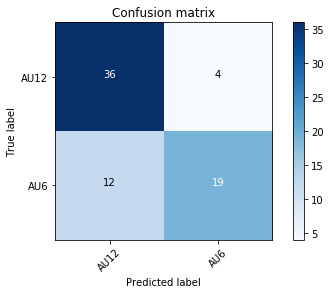

In [11]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

In [12]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook=m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [13]:
def display_cmap_img(dx,f2):
    plt.imshow(dx)
    plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot')
    
def normalise_features(sfs):
    feat = np.maximum(0,to_np(sfs[3].features[0]))

    f2 = np.dot(np.rollaxis(feat,0,3), py)
    f2 -= f2.min()
    f2 /= f2.max()  
    return f2

def get_pred(m,x):
    py = m(Variable(x.cuda()))
    py = np.exp(to_np(py)[0])
    return py

def return_saved_features(m):
    return [SaveFeatures(o) for o in [m[-7], m[-6], m[-5], m[-4]]]

def remove_saved_features(sfs):
    for o in sfs: o.remove()
        
def get_data_by_idx(idx,data):
    x,y = next(iter(data.val_dl))
    x,y = x[None,idx], y[None,idx]
    return x,y

def denormalise_data(data,x):
    return data.val_ds.denorm(x)[0]

In [44]:
# Create preds
preds = []
probs = []
for idx in range(data.bs):
    x,y = get_data_by_idx(idx,data)
    py = get_pred(m,x)

    preds.append(np.argmax(py))
    probs.append(py[1])

In [53]:
data_x,data_val_y = next(iter(data.val_dl))
data_val_y = np.array(data_val_y)
preds = np.asarray(preds)
probs = np.asarray(probs)

In [54]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data_val_y)==is_correct)

def plots(dxs, f2s, ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
#         plt.imshow(ims[i])
        dx = dxs[i]
        f2 = f2s[i]
        plt.imshow(dx)
        plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot')    

def load_img_id(ds, idx): 
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def load_img_ids(idx):
    x = data_x[None,idx]
    dx = data.val_ds.denorm(x)[0]
    return dx

def load_features_ids(idx):
    x = data_x[None,idx]
    sfs = [SaveFeatures(o) for o in [m[-7], m[-6], m[-5], m[-4]]]
    py = m(Variable(x.cuda()))
    for o in sfs: o.remove()
    py = np.exp(to_np(py)[0])
    feat = np.maximum(0,to_np(sfs[3].features[0]))
    f2 = np.dot(np.rollaxis(feat,0,3), py)
    f2 -= f2.min()
    f2 /= f2.max()
    return f2

def plot_val_with_title(idxs, title):
    print(idxs)
    imgs = [load_img_id(data.val_ds,idx) for idx in idxs]
    dxs = [load_img_ids(idx) for idx in idxs]
    f2s = [load_features_ids(idx) for idx in idxs]
    title_probs = [probs[idx] for idx in idxs]
    print(title)
    return plots(dxs, f2s, imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data_val_y)==is_correct) & (data_val_y == y), mult)

[31 29  4 60]
Most uncertain predictions


/home/sohaib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


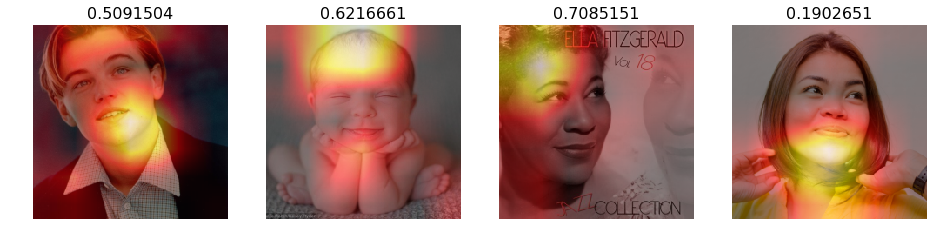

In [55]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

[43 13 42 26]
Most incorrect AU12 Lips


/home/sohaib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


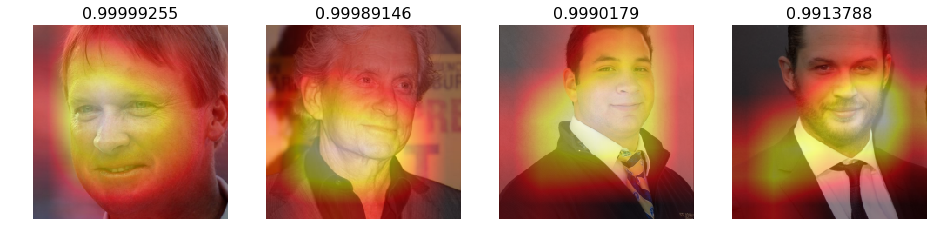

In [31]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect AU12 Lips")

[32 46 57 53]
Most incorrect AU6 cheeck


/home/sohaib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


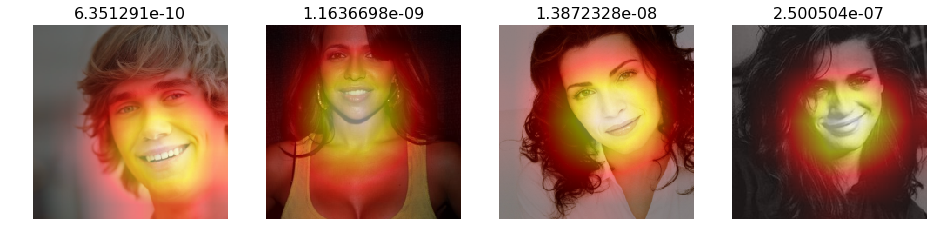

In [33]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect AU6 cheeck")

[16 11 17  5]
Most correct AU12 Lips


/home/sohaib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


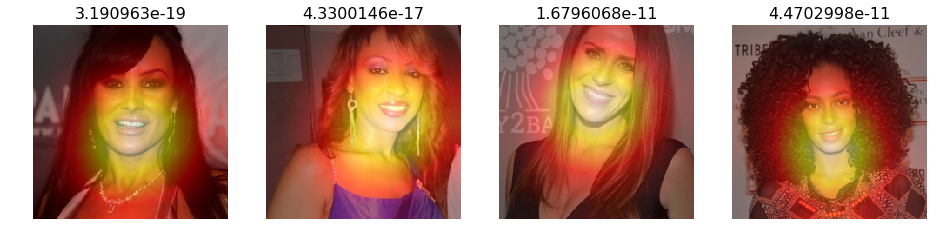

In [34]:
plot_val_with_title(most_by_correct(0, True), "Most correct AU12 Lips")

[50 62 45 58]
Most correct AU6 cheeck


/home/sohaib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


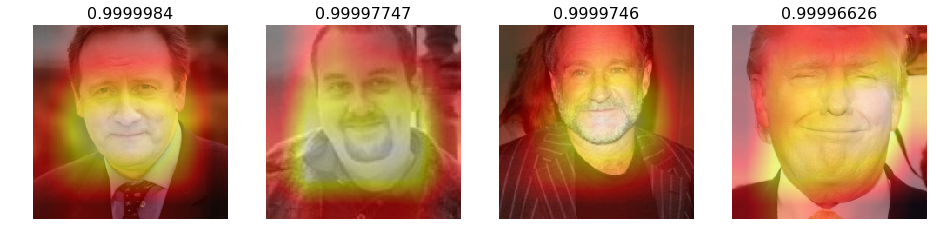

In [35]:
plot_val_with_title(most_by_correct(1, True), "Most correct AU6 cheeck")

In [336]:
# 33, 35, 47, 52 55 58 barbie <-- good 1 AU6 
# 44 53 <-- wrong AU6 
# 45, 48, 50, 51 54 57 AU6 but fires the mouth